In [1]:
import numpy as np

from prml.utils.datasets import RegressionDataGenerator,ClassificationDataGenerator2
from prml.utils.plot import plot_regression1D,plot_classifier
from prml.linear_classifier import Classifier 
from prml.linear_regression import LinearRegression

# Commity 

In [2]:
class Commity():
    def __init__(self,M) -> None:
        self.M = M 
        self.model = [LinearRegression(basis_function="polynomial",deg=3) for _ in range(M)]
    
    def fit(self,X,y):
        n = len(X) 
        sample = int(n*0.8) 
        for i in range(self.M):
            idx = np.random.randint(0,n,sample) 
            X_bootstrap,y_bootstrap = X[idx],y[idx] 
            self.model[i].fit(X_bootstrap,y_bootstrap) 
    
    def predict(self,X):
        y_pred = self.model[0].predict(X) 
        for i in range(self.M-1):
            y_pred += self.model[i+1].predict(X)
        return y_pred/self.M 

RMSE : 0.09542907146117496


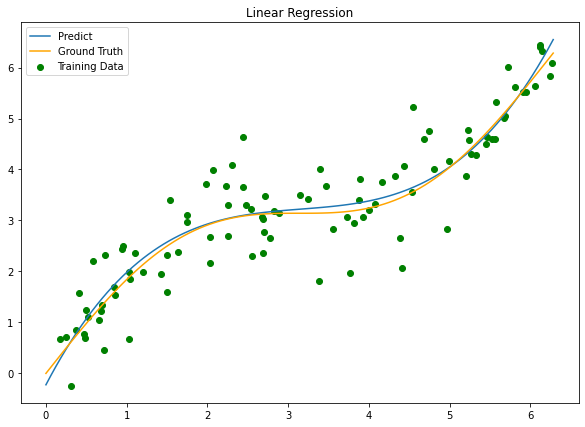

RMSE : 0.08863704353241803


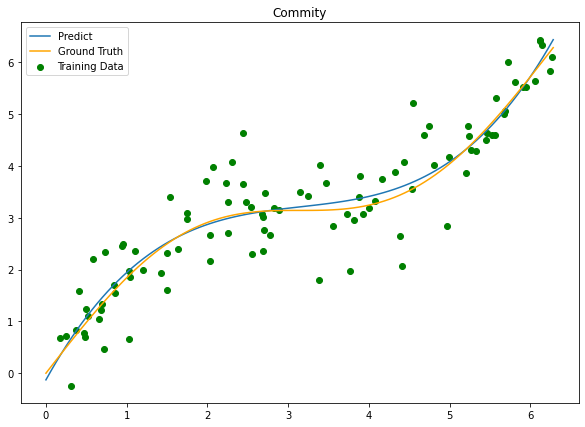

In [3]:
def f(x):
    return np.sin(x) + x 

generator = RegressionDataGenerator(f) 
X,y = generator(n=100,std=0.6) 

# in many cases, a commity model has worse results ..., maybe because of data size of each model is smaller than that of non commity model
lr = LinearRegression(basis_function="polynomial",deg=3) 
lr.fit(X,y)
plot_regression1D(X,y,lr,"Linear Regression",f)

com = Commity(M=5)
com.fit(X,y)
plot_regression1D(X,y,com,"Commity",f)

# AdaBoost

In [4]:
class AdaBoost(Classifier):
    """AdaBoost 

    weak_learner is decision stump

    Attributes:
        M (int): number of weak leaner 
        weak_leaner (list): list of data about weak learner 

    """
    def __init__(self,M=5) -> None:
        """__init__

        Args:
            M (int): number of weak leaner 

        """
        super(AdaBoost,self).__init__()
        self.M = M 

    def fit(self,X,y):
        """fit 

        only accept N_dim = 2 data

        Args:
            X (2-D array): shape = (N_samples,2),
            y (1-D array or 2-D array) : if 1-D array, y should be label-encoded, but 2-D arrray, y should be one-hot-encoded. should be 2-class data.  

        """
        y = self._onehot_to_label(y) 
        y[y == 0.0] = -1.0
        y = y.astype("int")
        N = len(X)
        sort_idx = np.argsort(X,axis=0)
        weight = np.ones(N)/N 
        weak_learner = [None]*self.M 

        for i in range(self.M):
            x_border,x_more_or_less,x_score = self._weak_learn(X[:,0],sort_idx[:,0],y,weight) 
            y_border,y_more_or_less,y_score = self._weak_learn(X[:,1],sort_idx[:,1],y,weight) 

            if x_score < y_score:
                ax = "x"
                border,more_or_less = x_border,x_more_or_less
            else:
                ax = "y" 
                border,more_or_less = y_border,y_more_or_less
            
            miss = self._miss_idx(X,y,ax,border,more_or_less) 
            eps = np.sum(miss*weight)/np.sum(weight) 
            alpha = np.log((1 - eps)/eps) 
            weight *= np.exp(alpha*miss) 

            weak_learner[i] = {
                "ax":ax,
                "border":border,
                "more_or_less":more_or_less,
                "alpha":alpha 
            }

        self.weak_learner = weak_learner 

    def _weak_learn(self,X,sort_idx,y,weight):
        weight_sum = weight.sum()
        more_score = weight[y != 1].sum() # score when all data is asigned 1

        border,more_or_less,score = X[sort_idx[0]]-1,"more",more_score 
        for i in range(len(X)):
            if y[sort_idx[i]] == 1:
                more_score += weight[sort_idx[i]]
            else:
                more_score -= weight[sort_idx[i]]

            less_score = weight_sum - more_score
            if more_score < score:
                border,more_or_less,score = X[sort_idx[i]],"more",more_score
            if less_score < score:
                border,more_or_less,score = X[sort_idx[i]],"less",less_score
        
        return border,more_or_less,score 
    
    def _miss_idx(self,X,y,ax,border,more_or_less):
        y_pred = self._predict(X,ax,border,more_or_less) 
        return (y_pred != y).astype("int")

    def _predict(self,X,ax,border,more_or_less):
        if more_or_less == "more":
            if ax == "x":
                class1 = X[:,0] > border 
            elif ax == "y":
                class1 = X[:,1] > border 
        elif more_or_less == "less":
            if ax == "x":
                class1 = X[:,0] <= border 
            elif ax == 'y':
                class1 = X[:,1] <= border 
        pred = np.zeros(len(X)) - 1
        pred[class1] = 1 
        return pred 

    def predict(self,X):
        """predict 

        Args:
            X (2-D array) : explanatory variable, shape = (N_samples,2)
        
        Returns: 
            y (1-D array or 2-D array) : if 1-D array, y should be label-encoded, but 2-D arrray, y should be one-hot-encoded. This depends on parameter y when fitting. 

        """

        y_pred = np.zeros(len(X))
        for i in range(self.M):
            pred = self._predict(
                X,
                self.weak_learner[i]["ax"],
                self.weak_learner[i]["border"],
                self.weak_learner[i]["more_or_less"],
            )
            y_pred += self.weak_learner[i]["alpha"]*pred
        
        y_pred = np.sign(y_pred)
        return self._inverse_transform(y_pred)

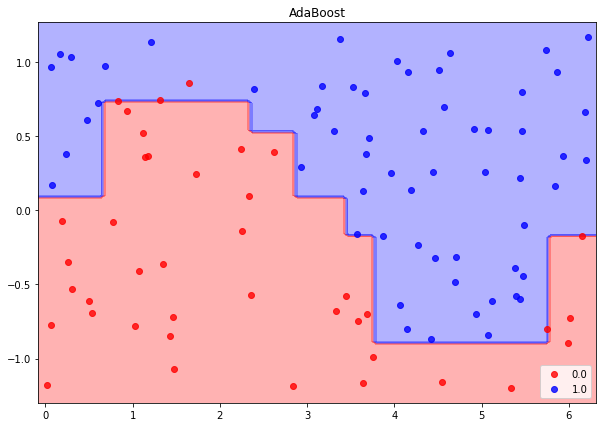

In [5]:
generator = ClassificationDataGenerator2(f=np.sin)
X,y = generator(n=100,x_lower=0,x_upper=2*np.pi,y_lower=-1.2,y_upper=1.2)

ab = AdaBoost(M=20)
ab.fit(X,y)
plot_classifier(X,y,ab,title="AdaBoost")

# CART

In [7]:
class CARTRegressor():
    """CARTRegressor 

    Attributes:
        lamda (float): regularizatioin parameter
        tree (object): parameter 

    """
    def __init__(self,lamda=1e-2):
        """__init__
        
        Args:
            lamda (float): regularizatioin parameter

        """
        self.lamda = lamda 

    def fit(self,X,y):
        """fit 

        Args:
            X (2-D array) : explanatory variable,shape = (N_samples,N_dim)
            y (1-D array) : target variable, shape = (N_samples) 
            
        """

        N = len(X)
        leaves = np.zeros(N)
        num_nodes = 1
        num_leaves = 1
        tree = []

        while True:
            if num_leaves == 0:
                break
            for leaf in range(num_nodes-num_leaves,num_nodes):
                idx = np.arange(N)[leaf == leaves]
                if len(idx) == 1:
                    num_leaves -= 1
                    tree.append({
                        "border": None, 
                        "target": y[idx][0]
                    }) # has no child
                    continue

                ax,border,score,more_index,less_index = -1,None,1e20,None,None
                for m in range(X.shape[1]):
                    now_border,now_score,now_more_index,now_less_index = self._find_boundry(idx,X[idx,m],y[idx])
                    if now_score < score:
                        ax,border,score,more_index,less_index = m,now_border,now_score,now_more_index,now_less_index

                if border is None: 
                    num_leaves -= 1
                    tree.append({
                        "border": None,
                        "target": y[idx].mean()
                    }) # has no child
                    continue

                tree.append({
                    "left_index": num_nodes, 
                    "right_index": num_nodes+1, 
                    "border": border, 
                    "ax": ax
                })

                leaves[less_index] = num_nodes
                leaves[more_index] = num_nodes+1 

                num_nodes += 2 
                num_leaves += 1

        self.tree = tree 

    def _find_boundry(self,idx,X,y):
        n = len(idx)
        sort_idx = np.argsort(X)
        all_sum = np.sum(y)
        right_sum = all_sum 

        # when all data is in one leaf
        score_now = self._error_function(y,right_sum/n) + self.lamda 
        border_index,score = None,score_now
        pred = np.zeros(n)

        for i in range(n-1):
            right_sum -= y[sort_idx[i]]
            left_sum = all_sum - right_sum
            pred[sort_idx[i+1:]] = right_sum/(n-i-1) 
            pred[sort_idx[:i+1]] = left_sum/(i+1)
            score_now = self._error_function(y,pred) + self.lamda*2
            if score_now < score:
                border_index,score = i,score_now
        
        if border_index is None: # no division
            return None,1e20,None,None 

        border = X[sort_idx[border_index]]
        more_index = idx[sort_idx[border_index+1:]] 
        less_index = idx[sort_idx[:border_index+1]]
        return border,score,more_index,less_index 
    
    def _error_function(self,y,pred):
        return np.mean((y-pred)**2)
    
    def _predict(self,X,p_id=0):
        if self.tree[p_id]["border"] is None: 
            return np.zeros(len(X)) + self.tree[p_id]["target"] 
        
        ax = self.tree[p_id]["ax"]
        border = self.tree[p_id]["border"]
        y = np.zeros(len(X))
        y[X[:,ax] > border] = self._predict(X[X[:,ax] > border],p_id=self.tree[p_id]["right_index"])
        y[X[:,ax] <= border] = self._predict(X[X[:,ax] <= border],p_id=self.tree[p_id]["left_index"])
        return y 

    def predict(self,X):
        """predict 

        Args:
            X (2-D array) : explanatory variable, shape = (N_samples,N_dim)
        
        Returns: 
            y (1-D array) : predictive value

        """
        y = self._predict(X)
        return y 

RMSE : 0.9834655649487981


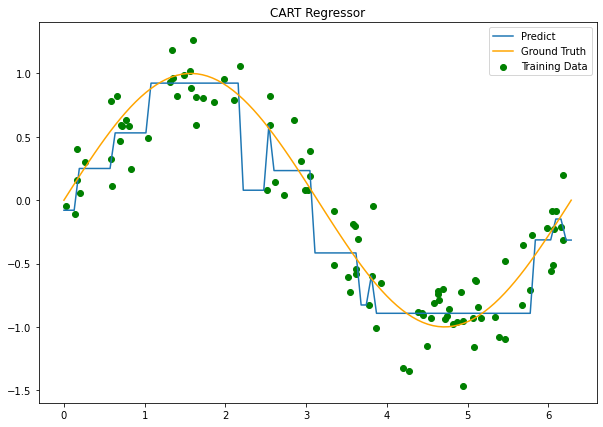

In [8]:
generator = RegressionDataGenerator(f=np.sin) 
X,y = generator(n=100,std=0.2)
cart = CARTRegressor(lamda=1e-2) 
cart.fit(X,y.ravel())
plot_regression1D(X,y,cart,title="CART Regressor",f=np.sin)